In [1]:
from hmr4d import os_chdir_to_proj_root

os_chdir_to_proj_root()

In [2]:
import torch
import numpy as np
from pathlib import Path
from hmr4d.utils.wis3d_utils import make_wis3d, add_motion_as_lines
from hmr4d.utils.net_utils import repeat_to_max_len
from hmr4d.utils.hml3d.metric import calculate_activation_statistics_np, calculate_frechet_distance_np

# Features
gt = torch.load("./hmr4d/utils/hml3d/gt_stat.pth")
all_emb = torch.load("tmp_dump_fid.pt", map_location="cpu")

# Motion
wis3d = make_wis3d(name="inspect_fid")
saved_files = {p.stem: torch.load(p) for p in sorted(Path("outputs/saved_generation").glob("*.pth"))}
print(saved_files["00000"].keys())


def update_saved_files_for_visualization(saved_files):
    """Make everything to 300 frames, with repeating last frames"""
    for k, data in saved_files.items():
        pred = data["pred"]
        gt = data["gt"]
        length = data["length"]
        # if not (pred.shape[0] == gt.shape[0] and pred.shape[0] == length):
        #     print(f"[{k}] pred {pred.shape}, gt {gt.shape}, length {length}")
        pred = repeat_to_max_len(pred[:length], 300, 0)
        gt = repeat_to_max_len(gt[:length], 300, 0)
        data["pred"] = pred
        data["gt"] = gt


update_saved_files_for_visualization(saved_files)

dict_keys(['pred', 'gt', 'text', 'length'])


In [3]:
#############################################
from hmr4d.utils.eval.torch_fid import compute_stats, compute_fid

# numpy implementation
# mu, cov = calculate_activation_statistics_np(all_emb.numpy())
# fid = calculate_frechet_distance_np(gt["mu"], gt["cov"], mu, cov)

pred_emb = all_emb.clone().requires_grad_()  # (N, 512)
gt_mu_ts = torch.from_numpy(gt["mu"]).float()  # (512,)
gt_cov_ts = torch.from_numpy(gt["cov"]).float()  # (512, 512)

mu, cov = compute_stats(pred_emb)
fid = compute_fid(gt_mu_ts, gt_cov_ts, mu, cov)
fid.backward()

# print
grad_abs_sum = pred_emb.grad.abs().sum(-1)
grad_desc_order = torch.argsort(grad_abs_sum, descending=True).tolist()
print("worst:", grad_desc_order[:5])
print("best:", grad_desc_order[-5:])

############################################

worst: [3033, 55, 559, 1761, 4078]
best: [1184, 2938, 3808, 2306, 414]


### Draw

In [10]:
# random choose a key
all_keys = list(saved_files.keys())
key = all_keys[np.random.randint(len(all_keys))]

# key_number = 614
key_number = 414
key = f"{key_number:05d}"

pred = saved_files[key]["pred"]
gt = saved_files[key]["gt"]
length = saved_files[key]["length"]
text = saved_files[key]["text"]
add_motion_as_lines(gt, wis3d, name="gt", const_color="green")
add_motion_as_lines(pred, wis3d, name="pred", const_color="blue")
print(f"[{key}] {text}")

[00414] the person sat down in the chair.


### FID w.r.t number of inputs

In [3]:
import torch
import numpy as np
from pathlib import Path
from hmr4d.utils.wis3d_utils import make_wis3d, add_motion_as_lines
from hmr4d.utils.net_utils import repeat_to_max_len
from hmr4d.utils.hml3d.metric import (
    calculate_activation_statistics_np,
    calculate_frechet_distance_np,
)

gt = torch.load("./hmr4d/utils/hml3d/gt_stat.pth")
all_emb = torch.load("tmp_dump_fid.pt")


<ErrorbarContainer object of 3 artists>

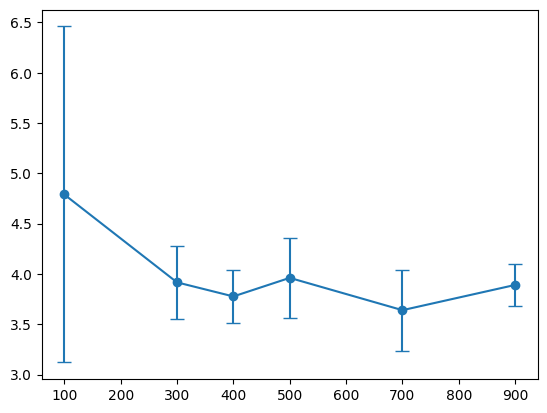

In [16]:
# use plt to draw the figure of std and mean
import matplotlib.pyplot as plt

N = 100

sample_times = 10
N_all = all_emb.shape[0]
N_to_fid_mean = {}
N_to_fid_std = {}

for N in [100, 300, 400, 500, 700, 900]:
    # get random indices of N
    fids = []
    for _ in range(sample_times):
        indices = torch.randint(0, N_all, (N,))
        mu, cov = calculate_activation_statistics_np(all_emb[indices].detach().cpu().numpy())
        fid = calculate_frechet_distance_np(gt["mu"], gt["cov"], mu, cov)
        fids.append(fid)
    fids = np.array(fids)
    N_to_fid_mean[N] = fids.mean()
    N_to_fid_std[N] = fids.std()


# 绘制带误差棒的图
x = list(N_to_fid_mean.keys())
y = list(N_to_fid_mean.values())
yerr = list(N_to_fid_std.values())
plt.errorbar(x, y, yerr=yerr, fmt="-o", capsize=5, label="FID Mean ± Std")